In [1]:
from stgcn import STGCN
from utils import generate_dataset, load_metr_la_data, get_normalized_adj
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import os
import pickle as pk

from shapely.geometry import Point
import matplotlib.pyplot as plt

import geopandas as gpd
# import numpy as np
# from datetime import datetime
from geopy.distance import distance
from pathlib import Path

In [2]:
#set plot parameters
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 72

## Preprocessing

In [7]:
def load_traffic_dataset(data_directory, pattern, metadata_filepath):
    """Load traffic sensor dataset with spatiotemporal resolution.
    
    """
    metadata = pd.read_csv(metadata_filepath, delimiter="\t")
    LATITUDE_MIN = metadata["Latitude"].min()
    LATITUDE_MAX = metadata["Latitude"].max()
    LONGTITUDE_MIN = metadata["Longitude"].min()
    LONGTITUDE_MAX = metadata["Longitude"].min()
    geometry = [Point(xy) for xy in zip(metadata['Longitude'], metadata['Latitude'])]
    
    # Coordinate reference system : WGS84
    crs = {'init': 'epsg:4326'}
    # Creating a Geographic data frame
    geographic_metadata = gpd.GeoDataFrame(metadata, crs=crs, geometry=geometry)
    
    coordinate = [(x, y) for x, y in zip(geographic_metadata['Latitude'], geographic_metadata['Longitude'])]
    geographic_metadata['coordinate'] = coordinate
    
    data_2022 = pd.DataFrame()
    for day_data in sorted((data_directory).glob(pattern)):
        print(day_data)
        day_data = pd.read_csv(day_data,sep=',', header=None)
        data_2022 = pd.concat([data_2022, day_data])
        
    data_2022 = data_2022.rename(columns={0:'Timestamp', 1:'Station', 2:'District', 3:'Freeway', 4:'Direction', 5:'Lane_Type', 6:'Length', 7:'Samples_1', 8:'%Pbserved', 9:'TotalFlow', 10:'AvgOccu', 11:'AvgSpeed', 12:'LaneNSamples', 13:'LaneNFlow', 14:'LaneNAvgOccu', 15:'LaneNAvgSpeed', 16:'LaneNobserved'})
    data_2022_filtered = data_2022.dropna(subset=['AvgSpeed'])
    data_2022_processed = data_2022_filtered[['Timestamp','Station','TotalFlow','AvgOccu','AvgSpeed']]
    
    #time convert
    date = pd.to_datetime(data_2022_processed['Timestamp'])
    data_2022_processed['Hour'] = date.dt.hour
    data_2022_processed['Weekday'] = date.dt.weekday
    data_2022_processed['Minute'] = date.dt.minute
    data_2022_processed['Second'] = date.dt.second
    data_2022_processed['Day'] = date.dt.day
    data_2022_processed['Month'] = date.dt.month
    data_2022_processed['Year'] = date.dt.year
    data_2022_processed.to_csv('data_2022_processed.csv', index=False)
    
    return geographic_metadata, data_2022_processed

def preprocess_traffic_dataset(geographic_metadata, data_2022_processed):
    data_2022_processed = data_2022_processed[data_2022_processed["Weekday"] < 5]
    geographic_metadata.dropna(axis=0, subset=["Latitude"], inplace=True)
    
    num_timepoints = len(data_2022_processed.Timestamp.unique())
    geographic_metadata_filtered = geographic_metadata.copy()
    for id_number in geographic_metadata['ID']:
        if (data_2022_processed['Station']==id_number).sum() != num_timepoints:
            bad_station_indices = geographic_metadata_filtered[geographic_metadata_filtered['ID']==id_number].index
            geographic_metadata_filtered = geographic_metadata_filtered.drop(bad_station_indices, axis=0)
    
    common_stations = np.intersect1d(data_2022_processed['Station'].unique(), geographic_metadata_filtered['ID'].unique())
    common_index = data_2022_processed['Station'].isin(common_stations)
    data_2022_processed = data_2022_processed[common_index]
    
    geographic_metadata_filtered = geographic_metadata_filtered.sort_values(by=["ID"])
    
    return geographic_metadata_filtered, data_2022_processed

def compute_distance_matrix(geographic_metadata_filtered):
    num_stations = len(geographic_metadata_filtered['ID'])
    point = geographic_metadata_filtered['coordinate'].tolist()
    distances = []
    D = np.zeros((num_stations, num_stations))
    for i in range(num_stations):
        for j in range(i, num_stations):
            d = distance(point[i], point[j]).m
            D[i, j] = d

    D[np.tril_indices(num_stations)] = D.T[np.tril_indices(num_stations)]
    
    return D

# D = np.array(distances).reshape(num_stations, num_stations)
def get_weighted_distances(D):
    sigma_threshold = 10000
    epsilon_threshold = 1e-5
    weighted_D = np.exp(-(D/sigma_threshold)**2)
    weighted_D[weighted_D<epsilon_threshold] = 0
    
    return weighted_D

In [4]:
data_directory = Path("../../station_5min_2022")
pattern = "d03_text_station_5min_2022_01*"
metadata_filepath = Path('../../station_5min_2022/d03_text_meta_2022_03_17.txt')

In [ ]:
geographic_metadata, data_2022_processed = load_traffic_dataset(data_directory, pattern, metadata_filepath)

In [8]:
geographic_metadata_filtered, data_2022_processed = preprocess_traffic_dataset(geographic_metadata, data_2022_processed)

In [9]:
D = compute_distance_matrix(geographic_metadata_filtered)
weighted_D = get_weighted_distances(D)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [260]:
len(data_2022_processed["Station"].unique())

939

In [297]:
def format_for_STGCN(data_2022_processed, num_subset_timepoints = 6000):
    """Format for STGCN.
    
    Returns:
        (num_stations, num_features, num_timepoints)
    """
    num_timepoints = len(data_2022_processed.Timestamp.unique())
    num_stations = len(data_2022_processed.Station.unique())
    
    sorted_data_2022 = data_2022_processed.sort_values(by=["Station", "Timestamp"])
    formatted_data_2022 = sorted_data_2022[["TotalFlow", "AvgSpeed"]].values.reshape((num_timepoints, num_stations, 2))
    
    formatted_data_2022 = formatted_data_2022.transpose((1, 2, 0))[:, :, :num_subset_timepoints]
    
    return formatted_data_2022

def random_split_dataset(formatted_data_2022, weighted_D, split_size):
    num_stations, _, _ = formatted_data_2022.shape
    
    subset_stations = np.full(num_stations, False)
    random_stations = np.random.choice(np.arange(num_stations), size=split_size)
    subset_stations[random_stations] = True
    
    X = formatted_data_2022[subset_stations, :].astype(np.float32)
    nonX = formatted_data_2022[~subset_stations, :].astype(np.float32)
    subset_weighted_D = weighted_D[subset_stations, :][:,subset_stations]
    nonsubset_weighted_D = weighted_D[~subset_stations, :][:, ~subset_stations]
    
    return (X, subset_weighted_D), (nonX, nonsubset_weighted_D), subset_stations

In [262]:
formatted_data_2022 = format_for_STGCN(data_2022_processed)

In [314]:
len(X)

372

In [313]:
split_size = len(formatted_data_2022) // 2
(X, subset_weighted_D), (incomplete_X, incomplete_subset_weighted_D), subset_stations = random_split_dataset(formatted_data_2022, weighted_D, split_size)

In [ ]:
def standardize_dataset(X):
    means = np.mean(X, axis=(0, 2))
    X = X - means.reshape(1, -1, 1)
    stds = np.std(X, axis=(0, 2))
    X = X / stds.reshape(1, -1, 1)
    
    return X, means, stds

X, means, stds = standardize_dataset(X)
incomplete_X, incomplete_means, incomplete_stds = standardize_dataset(incomplete_X)

In [ ]:
incomplete_X = incomplete_X[:len(X)]
incomplete_subset_weighted_D = incomplete_subset_weighted_D[:len(X), :len(X)]

In [ ]:
fig = plt.figure()
colorbar_ax = plt.imshow(incomplete_subset_weighted_D, cmap="hot")
fig.colorbar(colorbar_ax, ax=ax1)

## Training Imputational STGCN

In [ ]:
# Hyperparameters
torch.manual_seed(7)
device = "cuda:1"
num_timesteps_input = 12
num_timesteps_output = 3

lambda_imputation = 1
trained_with_imputation = False

epochs = 200
batch_size = 50

In [ ]:
from importlib import reload

In [ ]:
import stgcn
reload(stgcn)
import imputation
reload(imputation)
from stgcn import STGCN
from imputation import ImputationalSTGCN

In [ ]:
def train_epoch(training_input, training_target, A_wave, batch_size, optimizer, loss_criterion):
    """
    Trains one epoch with the given data.
    :param training_input: Training inputs of shape (num_samples, num_nodes,
    num_timesteps_train, num_features).
    :param training_target: Training targets of shape (num_samples, num_nodes,
    num_timesteps_predict).
    :param batch_size: Batch size to use during training.
    :return: Average loss for this epoch.
    """
    permutation = torch.randperm(training_input.shape[0])

    training_batches = training_input.shape[0] // batch_size
    epoch_training_losses = torch.zeros((training_batches, 4))
    with torch.autograd.set_detect_anomaly(True):
        for i in range(0, training_input.shape[0], batch_size):
            if i + batch_size > training_input.shape[0]:
                continue
            net.train()
            optimizer.zero_grad()

            indices = permutation[i:i + batch_size]
            X_batch, y_batch = training_input[indices], training_target[indices]
            X_batch = X_batch.to(device=device)
            y_batch = y_batch.to(device=device)

            out_complete, complete_attn_weights, out_incomplete, incomplete_attn_weights = net(A_wave, X_batch)

            loss_complete, loss_imputation, loss_consistency = imputation_loss(y_batch, out_complete, complete_attn_weights,
                                   out_incomplete, incomplete_attn_weights, loss_criterion)
            loss = loss_complete + loss_imputation + loss_consistency
#             print(loss)
#             2/0
    #         y_batch_incomplete = torch.einsum('bct,bic->bit', [y_batch, incomplete_attn_weights])
    #         y_batch_complete = torch.einsum('bct,bic->bit', [y_batch, complete_attn_weights])

    #         loss_complete = loss_criterion(out_complete, y_batch)
    #         loss_incomplete = loss_criterion(out_incomplete, y_batch_incomplete)
    #         loss_consistency = loss_criterion(y_batch, y_batch_complete)
    #         loss = loss_complete + loss_incomplete + loss_consistency
            loss.backward()
#             for n, p in net.weight_mapper.named_parameters():
#                 print(n, p)
#                 print(n, p.grad)

            optimizer.step()
        
            epoch_training_losses[i//batch_size, 0] = loss
            epoch_training_losses[i//batch_size, 1] = loss_complete
            epoch_training_losses[i//batch_size, 2] = lambda_imputation * loss_imputation
            epoch_training_losses[i//batch_size, 3] = loss_consistency
        
    return torch.mean(epoch_training_losses, axis=0)

In [ ]:
def imputation_loss(y_batch, out_complete, complete_attn_weights, out_incomplete,
                    incomplete_attn_weights, loss_criterion):
    """Compute loss for complete and incomplete datsets.
    
    """
    y_batch_incomplete = torch.einsum('bct,bic->bit', [y_batch, incomplete_attn_weights])
    y_batch_complete = torch.einsum('bct,bic->bit', [y_batch, complete_attn_weights])

#         print(f"incomplete_attn_weights: {incomplete_attn_weights[0]}")
#         print(f"complete_attn_weights: {complete_attn_weights[0]}")

#         print(f"y_batch: {y_batch[0]}")
#         print(f"y_batch_complete: {y_batch_complete[0]}")
#         print(f"y_batch_incomplete: {y_batch_incomplete[0]}")
    loss_complete = loss_criterion(out_complete, y_batch)
#         print(f"loss_complete: {loss_complete}")
    loss_imputation = loss_criterion(out_incomplete, y_batch_incomplete)
#         print(f"loss_incomplete: {loss_incomplete}")
    loss_consistency = loss_criterion(y_batch, y_batch_complete)
#         print(f"loss_consistency: {loss_consistency}")
#         loss = loss_complete + loss_incomplete + loss_consistency

    return (loss_complete, loss_imputation, loss_consistency)

In [ ]:
def test_epoch(test_input, test_target, A_wave, batch_size, loss_criterion):
    """
    Trains one epoch with the given data.
    :param training_input: Training inputs of shape (num_samples, num_nodes,
    num_timesteps_train, num_features).
    :param training_target: Training targets of shape (num_samples, num_nodes,
    num_timesteps_predict).
    :param batch_size: Batch size to use during training.
    :return: Average loss for this epoch.
    """
    permutation = torch.randperm(test_input.shape[0])

    epoch_training_losses = []
    for i in range(0, test_input.shape[0], batch_size):
        net.eval()

        indices = permutation[i:i + batch_size]
        X_batch, y_batch = test_input[indices], test_target[indices]
        X_batch = X_batch.to(device=device)
        y_batch = y_batch.to(device=device)

        with torch.no_grad():
            out_complete, complete_attn_weights, out_incomplete, incomplete_attn_weights = net(A_wave, X_batch)

            loss_complete, loss_imputation, loss_consistency = imputation_loss(y_batch, out_complete, complete_attn_weights,
                                       out_incomplete, incomplete_attn_weights, loss_criterion)
            loss = loss_complete + lambda_imputation * loss_imputation + loss_consistency
            
        epoch_training_losses.append(loss.detach().cpu().numpy())
        
    return sum(epoch_training_losses)/len(epoch_training_losses)

In [264]:
def test_epoch_with_imputation(test_input, test_target, A_wave, batch_size, loss_criterion,
                               incomplete_input, incomplete_A_wave):
    """
    Trains one epoch with the given data.
    :param training_input: Training inputs of shape (num_samples, num_nodes,
    num_timesteps_train, num_features).
    :param training_target: Training targets of shape (num_samples, num_nodes,
    num_timesteps_predict).
    :param batch_size: Batch size to use during training.
    :return: Average loss for this epoch.
    """
    permutation = torch.randperm(test_input.shape[0])
    incomplete_permutation = torch.randperm(incomplete_input.shape[0])
    
    test_batches = test_input.shape[0] // batch_size
    incomplete_batches = incomplete_input.shape[0] // batch_size
    epoch_training_losses = torch.zeros((test_batches, incomplete_batches, 4))
    net.eval()
    
    print(test_input.shape[0])
    for i in range(0, test_input.shape[0], batch_size):
        if i + batch_size > test_input.shape[0]:
            continue
        indices = permutation[i:i + batch_size]
        X_batch, y_batch = test_input[indices], test_target[indices]
        X_batch = X_batch.to(device=device)
        y_batch = y_batch.to(device=device)
        for j in range(0, incomplete_input.shape[0], batch_size):
            if j + batch_size > incomplete_input.shape[0]:
                continue
            with torch.no_grad():
                incomplete_indices = incomplete_permutation[j:j + batch_size]
                incomplete_X_batch = incomplete_input[incomplete_indices]
                incomplete_X_batch = incomplete_X_batch.to(device=device)
                out_complete, complete_attn_weights, out_incomplete, incomplete_attn_weights = net(A_wave, X_batch, incomplete_X_batch, incomplete_A_wave)
                loss_complete, loss_imputation, loss_consistency = imputation_loss(y_batch, out_complete, complete_attn_weights,
                                       out_incomplete, incomplete_attn_weights, loss_criterion)
                loss = loss_complete + lambda_imputation * loss_imputation + loss_consistency

            epoch_training_losses[i//batch_size, j//batch_size, 0] = loss
            epoch_training_losses[i//batch_size, j//batch_size, 1] = loss_complete
            epoch_training_losses[i//batch_size, j//batch_size, 2] = lambda_imputation * loss_imputation
            epoch_training_losses[i//batch_size, j//batch_size, 3] = loss_consistency
        
    return torch.mean(epoch_training_losses, axis=(0, 1))

In [265]:
def train_epoch_with_imputation(training_input, training_target, A_wave, batch_size, optimizer, loss_criterion,
                               incomplete_input, incomplete_A_wave):
    """
    Trains one epoch with the given data.
    :param training_input: Training inputs of shape (num_samples, num_nodes,
    num_timesteps_train, num_features).
    :param training_target: Training targets of shape (num_samples, num_nodes,
    num_timesteps_predict).
    :param batch_size: Batch size to use during training.
    :return: Average loss for this epoch.
    """
    permutation = torch.randperm(training_input.shape[0])
    incomplete_permutation = torch.randperm(incomplete_input.shape[0])
    
    training_batches = training_input.shape[0] // batch_size
    incomplete_batches = incomplete_input.shape[0] // batch_size
    epoch_training_losses = torch.zeros((training_batches, incomplete_batches, 4))
    net.eval()
    
    print(training_input.shape[0])
    for i in range(0, training_input.shape[0], batch_size):
        print(i)
        if i + batch_size > training_input.shape[0]:
            continue
        indices = permutation[i:i + batch_size]
        X_batch, y_batch = training_input[indices], training_target[indices]
        X_batch = X_batch.to(device=device)
        y_batch = y_batch.to(device=device)
        for j in range(0, incomplete_input.shape[0], batch_size):
            if j + batch_size > incomplete_input.shape[0]:
                continue
            incomplete_indices = incomplete_permutation[j:j + batch_size]
            incomplete_X_batch = incomplete_input[incomplete_indices]
            incomplete_X_batch = incomplete_X_batch.to(device=device)
            out_complete, complete_attn_weights, out_incomplete, incomplete_attn_weights = net(A_wave, X_batch, incomplete_X_batch, incomplete_A_wave)
            loss_complete, loss_imputation, loss_consistency = imputation_loss(y_batch, out_complete, complete_attn_weights,
                                   out_incomplete, incomplete_attn_weights, loss_criterion)
            loss = loss_complete + lambda_imputation * loss_imputation + loss_consistency

            loss.backward()

            optimizer.step()

            epoch_training_losses[i//batch_size, j//batch_size, 0] = loss
            epoch_training_losses[i//batch_size, j//batch_size, 1] = loss_complete
            epoch_training_losses[i//batch_size, j//batch_size, 2] = lambda_imputation * loss_imputation
            epoch_training_losses[i//batch_size, j//batch_size, 3] = loss_consistency
        
    return torch.mean(epoch_training_losses, axis=(0, 1))

In [284]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [267]:
split_line1 = int(X.shape[2] * 0.6)
split_line2 = int(X.shape[2] * 0.7)

incomplete_split_line1 = int(incomplete_X.shape[2] * 0.2)
incomplete_split_line2 = int(incomplete_X.shape[2] * 0.3)

train_original_data = X[:, :, :split_line1]
val_original_data = X[:, :, split_line1:split_line2]
test_original_data = X[:, :, split_line2:]

train_incomplete_data = incomplete_X[:, :, :incomplete_split_line1]
val_incomplete_data = incomplete_X[:, :, incomplete_split_line1:incomplete_split_line2]
test_incomplete_data = incomplete_X[:, :, incomplete_split_line2:]

training_input, training_target = generate_dataset(train_original_data,
                                                   num_timesteps_input=num_timesteps_input,
                                                   num_timesteps_output=num_timesteps_output)
val_input, val_target = generate_dataset(val_original_data,
                                         num_timesteps_input=num_timesteps_input,
                                         num_timesteps_output=num_timesteps_output)
test_input, test_target = generate_dataset(test_original_data,
                                           num_timesteps_input=num_timesteps_input,
                                           num_timesteps_output=num_timesteps_output)

incomplete_training_input, incomplete_training_target = generate_dataset(train_incomplete_data,
                                           num_timesteps_input=num_timesteps_input,
                                           num_timesteps_output=num_timesteps_output)

incomplete_test_input, incomplete_test_target = generate_dataset(test_incomplete_data,
                                           num_timesteps_input=num_timesteps_input,
                                           num_timesteps_output=num_timesteps_output)

A_wave = get_normalized_adj(subset_weighted_D).astype(np.float32)
A_wave = torch.from_numpy(A_wave)
A_wave = A_wave.to(device=device)

non_A_wave = get_normalized_adj(subset_weighted_D).astype(np.float32)
non_A_wave = torch.from_numpy(non_A_wave)

non_A_wave = non_A_wave.to(device=device)
print(A_wave.dtype)

torch.float32


In [268]:
non_loss = test_epoch(incomplete_input.to(device=device), incomplete_target.to(device=device), non_A_wave.to(device=device), batch_size, loss_criterion)
print("Non loss: {}".format(non_loss))

Non loss: 1.1773503854870797


In [ ]:
net = ImputationalSTGCN(A_wave.shape[0],
            training_input.shape[3],
            num_timesteps_input,
            num_timesteps_output).to(device=device)

# with torch.no_grad():
#     val_input = val_input.to(device=device)
#     net(A_wave, val_input)
#     val_input = val_input.to(device="cpu")

# 2/0
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss_criterion = nn.MSELoss()

training_losses = torch.zeros((epochs, 4))
validation_losses = torch.zeros((epochs, 4))
validation_maes = np.zeros((epochs,))
for epoch in range(epochs):
    print(f"----- Epoch {epoch} -----")
#     training_loss = train_epoch(training_input, training_target,
#                        batch_size=batch_size, optimizer=optimizer, loss_criterion=loss_criterion)
    if trained_with_imputation:
        training_loss, training_loss_complete, training_loss_imputation, training_loss_consistency = train_epoch_with_imputation(
            training_input, training_target, A_wave, batch_size, optimizer, loss_criterion, incomplete_training_input, non_A_wave)
    else:
        training_loss, training_loss_complete, training_loss_imputation, training_loss_consistency = train_epoch(training_input, training_target, A_wave,
                       batch_size=batch_size, optimizer=optimizer, loss_criterion=loss_criterion)

    training_losses[epoch, 0] = training_loss
    training_losses[epoch, 1] = training_loss_complete
    training_losses[epoch, 2] = training_loss_imputation
    training_losses[epoch, 3] = training_loss_consistency

    # Run validation
    with torch.no_grad():
        net.eval()
        val_input = val_input.to(device=device)
        val_target = val_target.to(device=device)

        out_complete, complete_attn_weights, out_incomplete, incomplete_attn_weights = net(A_wave, val_input)
        (val_loss_complete, val_loss_imputation, val_loss_consistency) = imputation_loss(val_target, out_complete, complete_attn_weights,
                                   out_incomplete, incomplete_attn_weights, loss_criterion)
        val_loss = (val_loss_complete + lambda_imputation * val_loss_imputation + val_loss_consistency)
#         val_loss = loss_criterion(out_complete, val_target).to(device="cpu")
        validation_losses[epoch, 0] = val_loss
        validation_losses[epoch, 1] = val_loss_complete
        validation_losses[epoch, 2] = val_loss_imputation
        validation_losses[epoch, 3] = val_loss_consistency

        out_unnormalized = out_complete.detach().cpu().numpy()*stds[0] + means[0]
        target_unnormalized = val_target.detach().cpu().numpy()*stds[0] + means[0]
        mae = np.mean(np.absolute(out_unnormalized - target_unnormalized))
        validation_maes[epoch] = mae

        out = None
        val_input = val_input.to(device="cpu")
        val_target = val_target.to(device="cpu")

    print("Training loss: {}".format(training_losses[epoch][0]))
    print("Validation loss: {}".format(validation_losses[epoch][0]))
    print("Validation MAE: {}".format(validation_maes[epoch]))

    checkpoint_path = Path("checkpoints/")
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    with open("checkpoints/losses_imputation.pk", "wb") as fd:
        pk.dump((training_losses, validation_losses, validation_maes), fd)
    
    model_path = f"model_lambda_imputation_{lambda_imputation}_batch_size_{batch_size}_trained_with_imputation_{trained_with_imputation}_epoch_{epoch}"
    torch.save(net.state_dict(), checkpoint_path / model_path)

In [ ]:
training_losses = training_losses.detach().cpu().numpy()
validation_losses = validation_losses.detach().cpu().numpy()

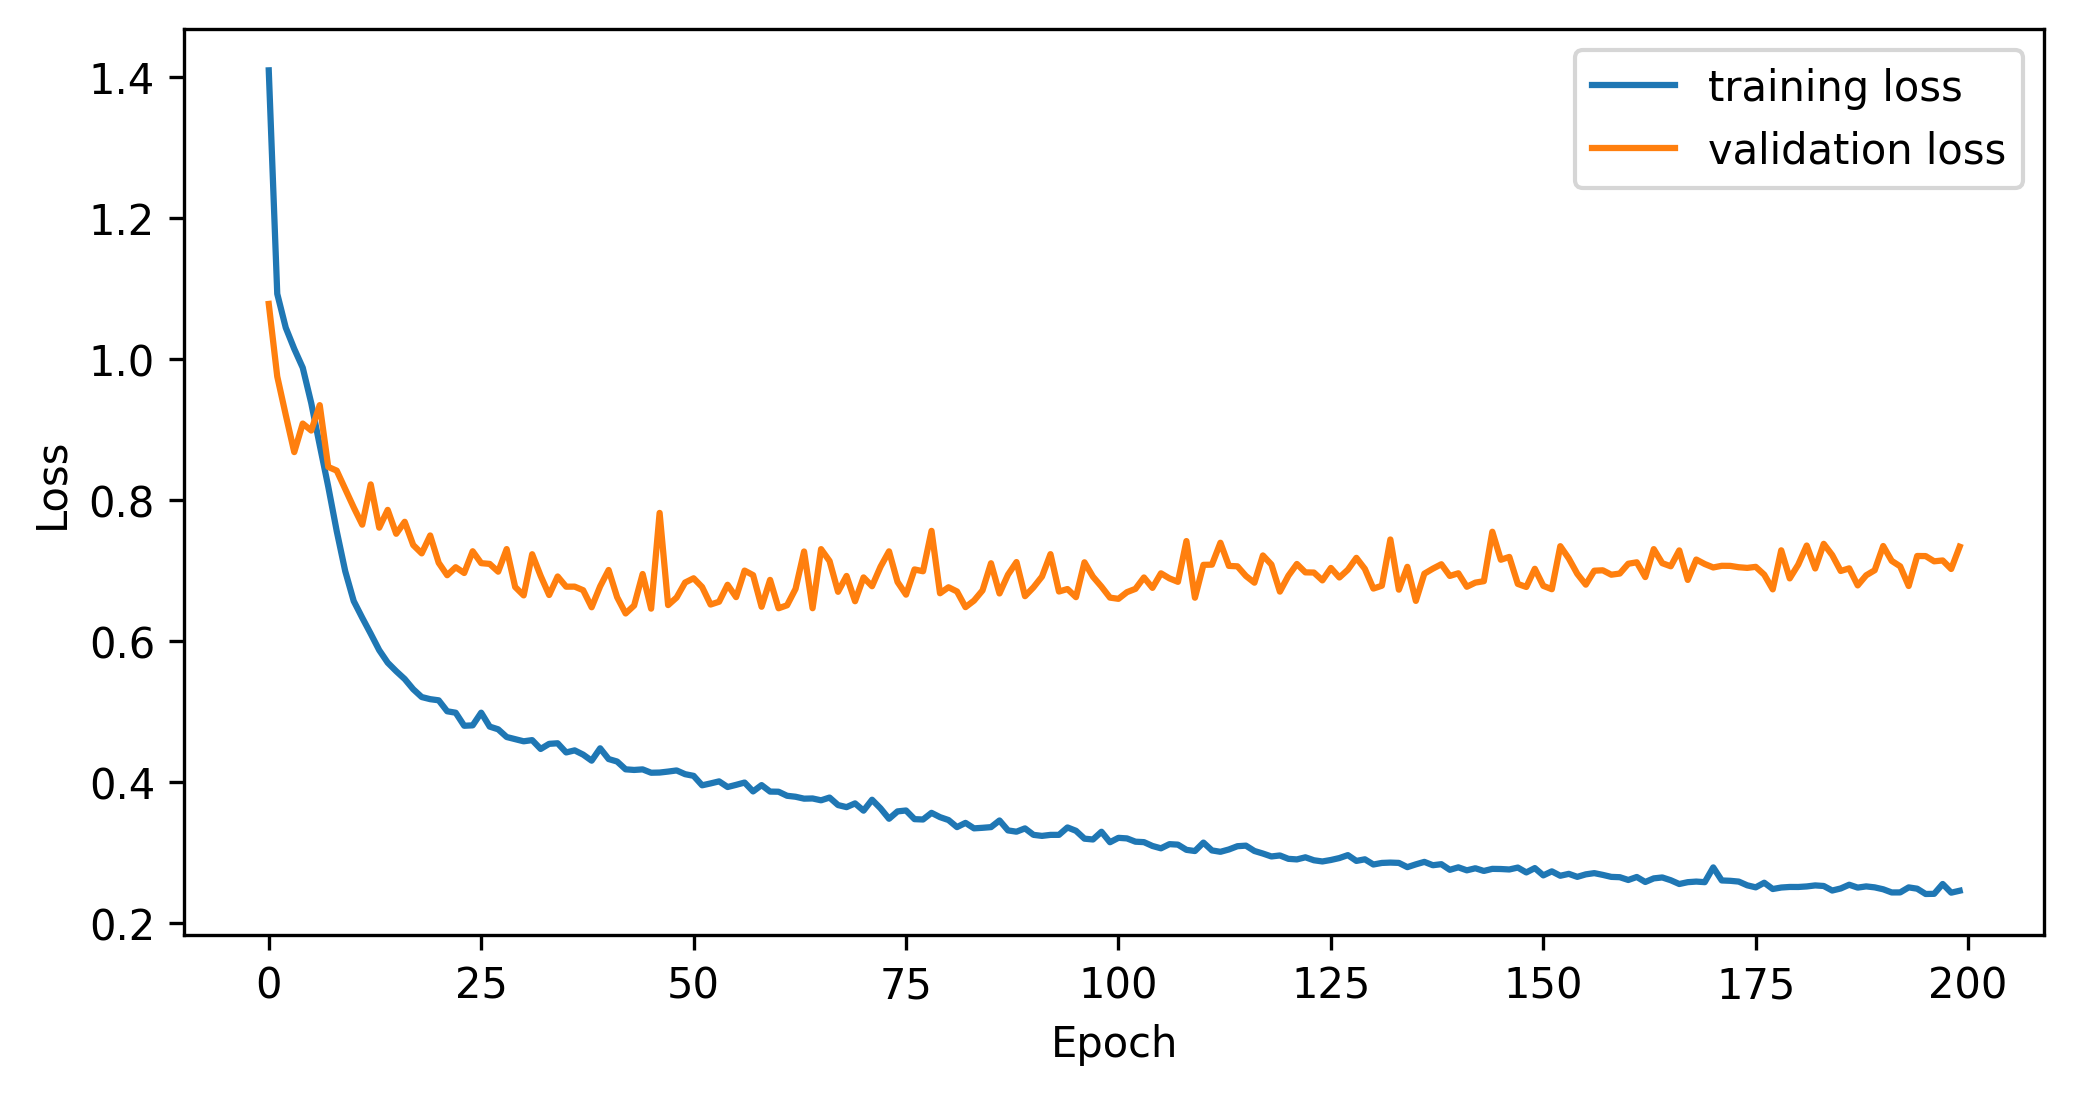

In [279]:
plt.figure(figsize=(8, 4), dpi=300)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(training_losses[:, 0], label="training loss")
plt.plot(validation_losses[:, 0], label="validation loss")
plt.legend()
plt.show()

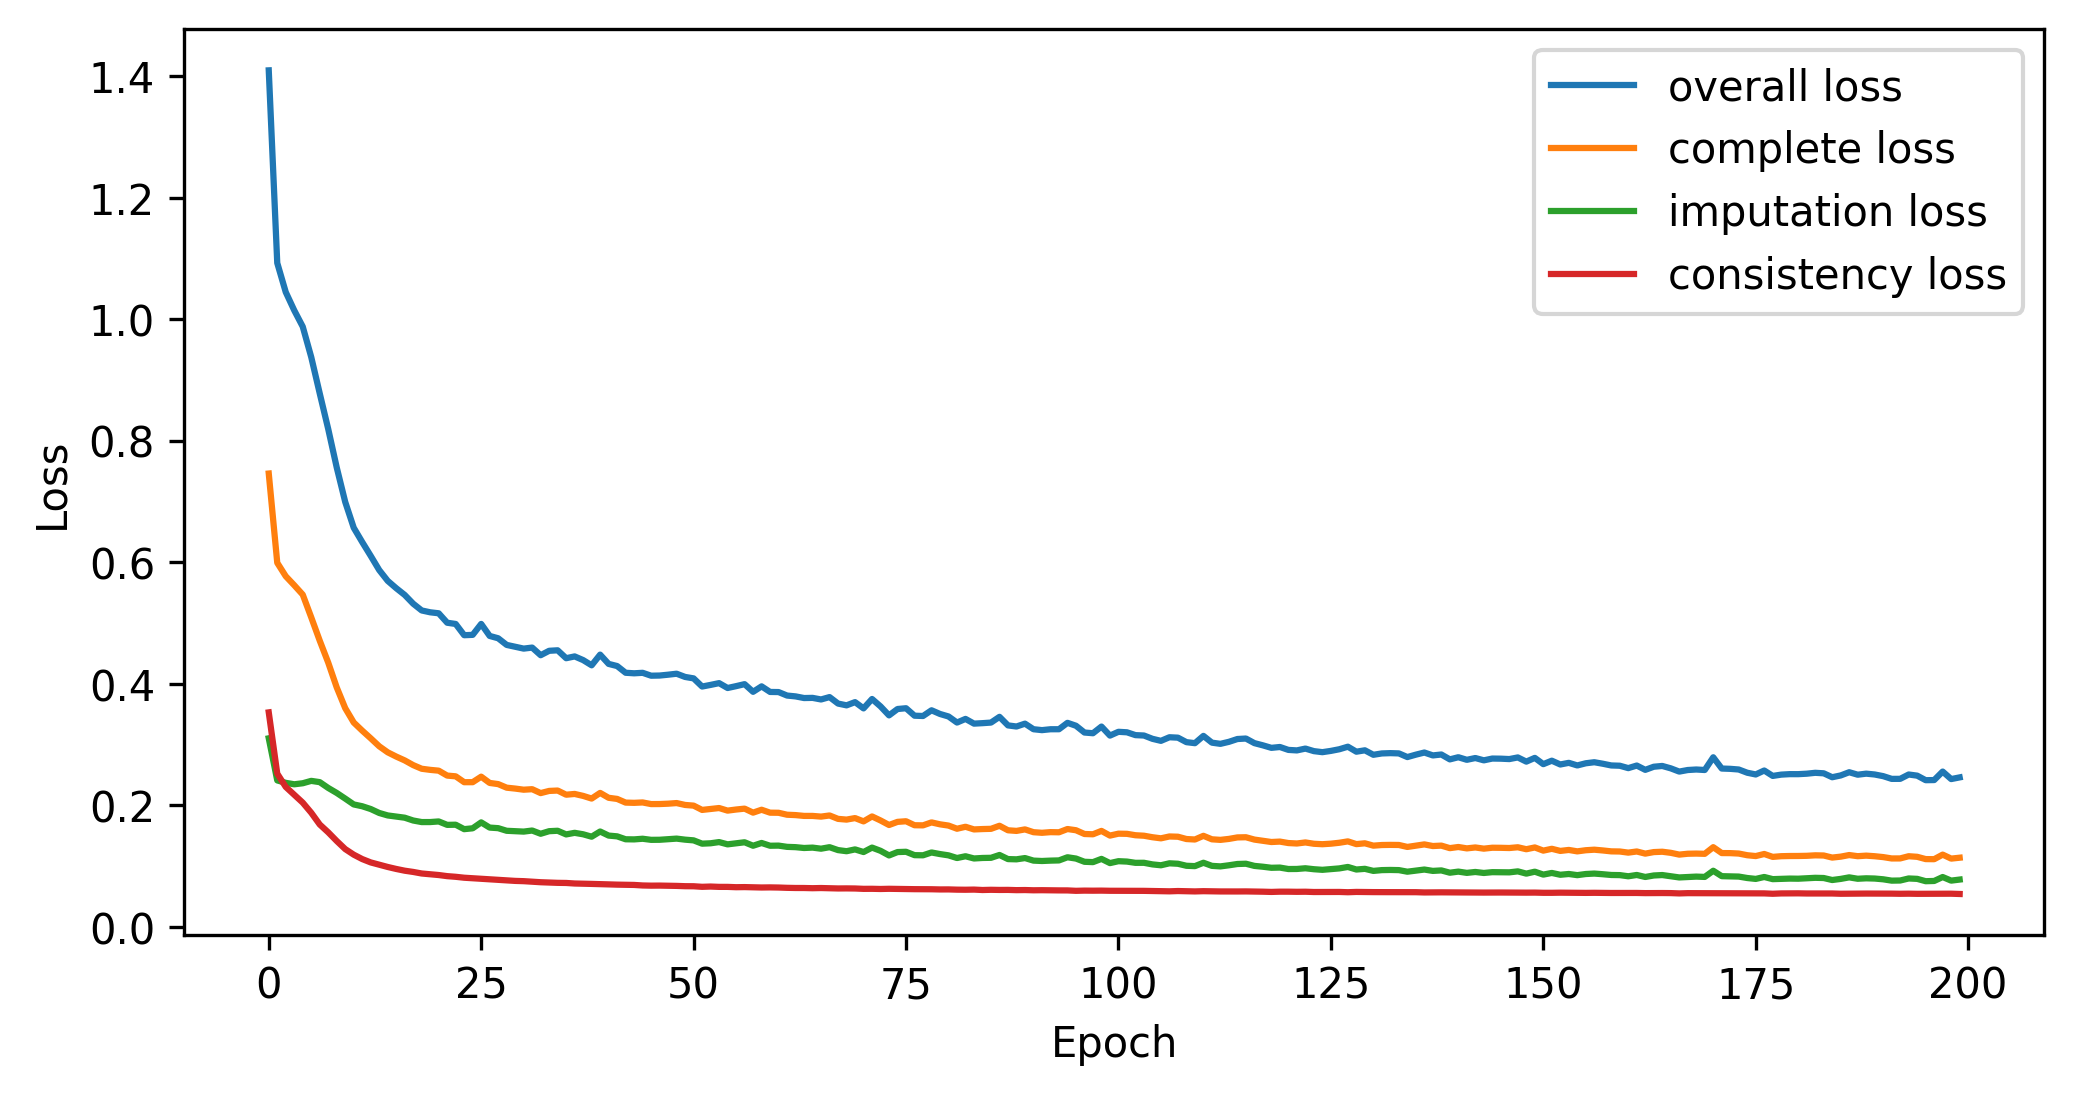

In [278]:
plt.figure(figsize=(8, 4), dpi=300)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(training_losses[:, 0], label="overall loss")
plt.plot(training_losses[:, 1], label="complete loss")
plt.plot(training_losses[:, 2], label="imputation loss")
plt.plot(training_losses[:, 3], label="consistency loss")
plt.legend()
plt.show()

In [166]:
net = ImputationalSTGCN(A_wave.shape[0],
            training_input.shape[3],
            num_timesteps_input,
            num_timesteps_output).to(device=device)
net.load_state_dict(torch.load(checkpoint_path / model_path))
net.eval()

ImputationalSTGCN(
  (complete_predictor): STGCN(
    (block1): STGCNBlock(
      (temporal1): TimeBlock(
        (conv1): Conv2d(2, 64, kernel_size=(1, 3), stride=(1, 1))
        (conv2): Conv2d(2, 64, kernel_size=(1, 3), stride=(1, 1))
        (conv3): Conv2d(2, 64, kernel_size=(1, 3), stride=(1, 1))
      )
      (temporal2): TimeBlock(
        (conv1): Conv2d(16, 64, kernel_size=(1, 3), stride=(1, 1))
        (conv2): Conv2d(16, 64, kernel_size=(1, 3), stride=(1, 1))
        (conv3): Conv2d(16, 64, kernel_size=(1, 3), stride=(1, 1))
      )
      (batch_norm): BatchNorm2d(369, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): STGCNBlock(
      (temporal1): TimeBlock(
        (conv1): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1))
        (conv3): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1))
      )
      (temporal2): TimeBlock(
        (conv1): Conv2d(16, 64, kernel_size=(1,

In [141]:
test_input = test_input.to(device=device)
test_target = test_target.to(device=device)

test_loss = test_epoch(test_input, test_target, A_wave, batch_size, loss_criterion)

# out_unnormalized = out.detach().cpu().numpy()*stds[0]+means[0]
# target_unnormalized = test_target.detach().cpu().numpy()*stds[0]+means[0]
# test_mae = np.mean(np.absolute(out_unnormalized - target_unnormalized))

# out = None
# test_input = test_input.to(device="cpu")
# test_target = test_target.to(device="cpu")

print("Test loss: {}".format(test_loss))
# print("Test MAE: {}".format(test_mae))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [145]:
incomplete_target.dtype

torch.float32

In [202]:
non_loss = test_epoch(incomplete_test_input, incomplete_test_target, non_A_wave, batch_size, loss_criterion)
print("Non loss: {}".format(non_loss))

Non loss: 2.033164438274172


In [280]:
non_loss = test_epoch_with_imputation(test_input, test_target, A_wave, batch_size, loss_criterion, incomplete_test_input, non_A_wave)
print("Non loss: {}".format(non_loss))

1786
Non loss: tensor([1.9416, 0.4879, 1.3783, 0.0754])


In [171]:
36 * 369 * 24

318816

In [290]:
permutation = torch.randperm(test_input.shape[0])

net.eval()

indices = permutation[:2 * batch_size]
X_batch, y_batch = test_input[indices], test_input[indices]
X_batch = X_batch.to(device=device)
y_batch = y_batch.to(device=device)

incomplete_indices = permutation[:2 * batch_size]
incomplete_X_batch= incomplete_input[indices]
incomplete_X_batch = incomplete_X_batch.to(device=device)

out_complete, complete_attn_weights, out_incomplete, incomplete_attn_weights = net(A_wave, X_batch, incomplete_X_batch, non_A_wave)

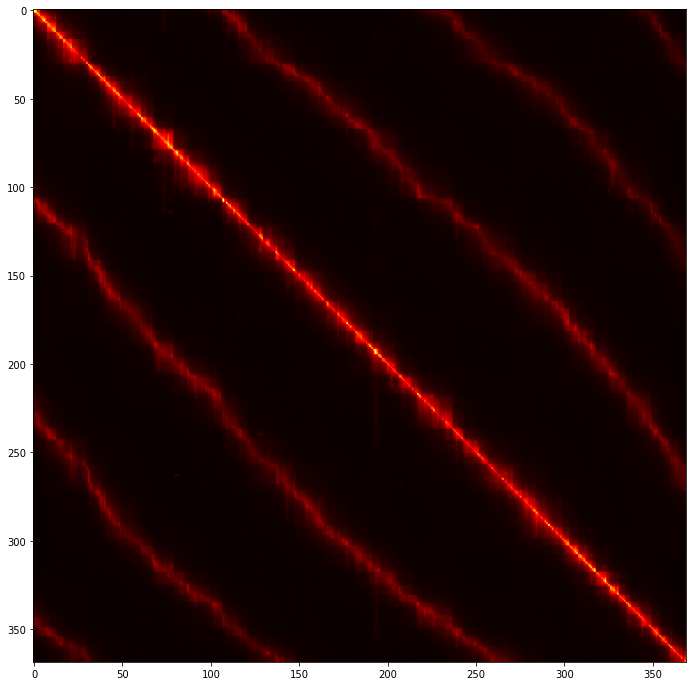

In [294]:
plt.imshow(complete_attn_weights.mean(axis=0).cpu().detach().numpy(), cmap="hot")

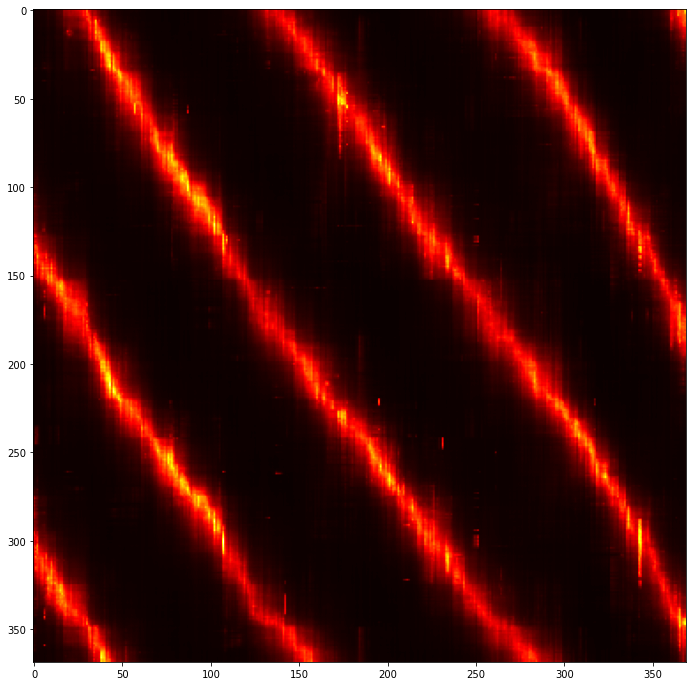

In [295]:
plt.imshow(incomplete_attn_weights.mean(axis=0).cpu().detach().numpy(), cmap="hot")

In [301]:
len(X)

345

<AxesSubplot:>

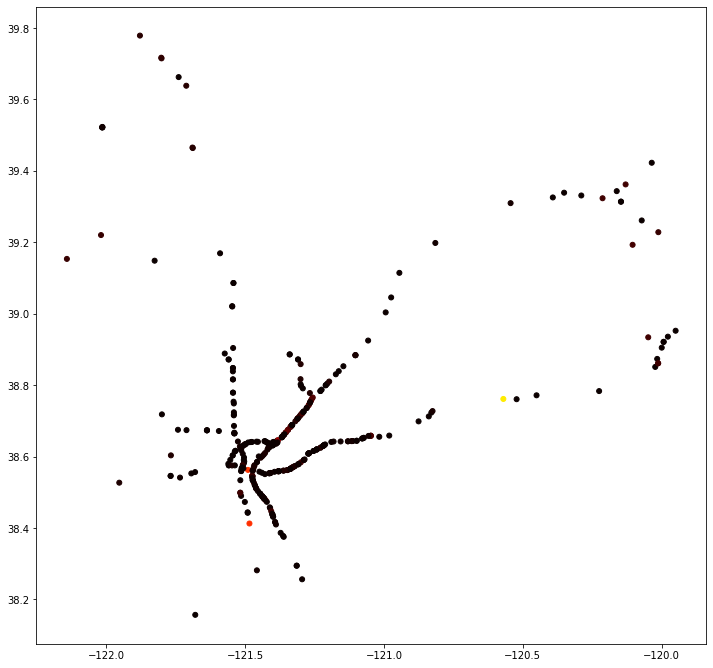

In [321]:
non_subset = geographic_metadata_filtered.iloc[subset_stations][:len(complete_attn_weights[0])]
non_subset["station_1"] = complete_attn_weights[:, 1].mean(axis=0).detach().cpu().numpy()
fig, ax1=plt.subplots()
non_subset.plot(ax=ax1, column="station_1", marker='o', markersize=25, cmap="hot")

In [296]:
geographic_metadata_filtered.iloc[~subset_stations].plot(ax=ax1, marker='o', color='b', markersize=0.5)

<AxesSubplot:>

<Figure size 864x864 with 0 Axes>